
# ChromaDB Explorer Notebook

This notebook provides an interactive way to explore your ChromaDB instance, inspect collections, view documents, and visualize embeddings.


In [ ]:
import chromadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Configuration ---
# Set the path to your ChromaDB persistent directory
# Make sure this path is correct relative to where you run the notebook
CHROMA_DB_PATH = "./chroma_db"

# Initialize ChromaDB client
client = chromadb.PersistentClient(path=CHROMA_DB_PATH)
print(f"ChromaDB client initialized, connected to: {CHROMA_DB_PATH}")


## 1. List Collections

Run the cell below to see all available collections in your ChromaDB.


In [3]:

collections = client.list_collections()
if collections:
    print("Available Collections:")
    for i, collection in enumerate(collections):
        print(f"{i+1}. {collection.name}")
else:
    print("No collections found in the database.")


Available Collections:
1. research_agent_collection



## 2. Select a Collection and Inspect its Content

Enter the name of the collection you want to inspect. If you don't specify one, it will try to select the first available collection.


In [ ]:
selected_collection_name = input("Enter collection name (or leave blank to select the first one): ").strip()

if not selected_collection_name and collections:
    selected_collection = collections[0]
    selected_collection_name = selected_collection.name
    print(f"No collection name entered, selecting the first one: {selected_collection_name}")
elif selected_collection_name:
    try:
        selected_collection = client.get_collection(name=selected_collection_name)
        print(f"Selected collection: {selected_collection_name}")
    except Exception as e:
        print(f"Error: Collection '{selected_collection_name}' not found. Please check the name and try again. {e}")
        selected_collection = None
else:
    print("No collections available to select.")
    selected_collection = None

if selected_collection:
    # Get all documents from the collection
    try:
        total_count = selected_collection.count()
        print(f"Total documents in collection '{selected_collection_name}': {total_count}")
        
        # Load ALL documents for complete analysis and visualization
        print(f"Loading all {total_count} documents (this may take a moment for large collections)...")
        results = selected_collection.get(
            ids=None, 
            where=None, 
            limit=total_count, 
            include=['documents', 'metadatas', 'embeddings']
        )
        
        documents = results['documents']
        metadatas = results['metadatas']
        embeddings = results['embeddings']
        ids = results['ids']

        print(f"Successfully loaded {len(documents)} documents with embeddings.")

        if documents:
            # Display first 5 documents as a sample
            df = pd.DataFrame({
                'id': ids[:5],
                'document': documents[:5],
                'metadata': metadatas[:5]
            })
            print("\nSample Documents (showing first 5):")
            display(df)

            print("\nMetadata Keys Distribution:")
            all_metadata_keys = []
            for meta in metadatas:
                if meta: # Ensure metadata is not None
                    all_metadata_keys.extend(meta.keys())
            if all_metadata_keys:
                metadata_key_counts = pd.Series(all_metadata_keys).value_counts()
                display(metadata_key_counts)
            else:
                print("No metadata found for these documents.")
        else:
            print("No documents found in the selected collection.")

    except Exception as e:
        print(f"Error retrieving documents from collection: {e}")
else:
    print("Cannot proceed without a selected collection.")

## 2.1 Database Content Analysis

This section provides detailed statistics about your database content including all source documents, chunk counts, and size analysis.

In [ ]:
if 'selected_collection' in locals() and selected_collection and 'documents' in locals() and documents:
    print("="*80)
    print("DATABASE CONTENT ANALYSIS")
    print("="*80)
    
    total_count = len(documents)
    print(f"\nAnalyzing {total_count} document chunks...\n")
    
    # Extract sources
    sources = [m.get('source', 'unknown') if m else 'unknown' for m in metadatas]
    
    # Create comprehensive analysis DataFrame
    analysis_df = pd.DataFrame({
        'id': ids,
        'source': sources,
        'chunk_length': [len(doc) for doc in documents],
        'word_count': [len(doc.split()) for doc in documents]
    })
    
    # 1. SOURCE DOCUMENT ANALYSIS
    print("="*80)
    print("1. SOURCE DOCUMENTS")
    print("="*80)
    
    source_stats = analysis_df.groupby('source').agg({
        'id': 'count',
        'chunk_length': ['mean', 'min', 'max', 'std'],
        'word_count': ['mean', 'min', 'max']
    }).round(2)
    
    source_stats.columns = ['Chunk Count', 
                           'Avg Chars', 'Min Chars', 'Max Chars', 'Std Chars',
                           'Avg Words', 'Min Words', 'Max Words']
    
    # Sort by chunk count descending
    source_stats = source_stats.sort_values('Chunk Count', ascending=False)
    
    print(f"\nTotal unique source documents: {len(source_stats)}")
    print(f"\nDetailed breakdown by source:\n")
    display(source_stats)
    
    # 2. OVERALL STATISTICS
    print("\n" + "="*80)
    print("2. OVERALL CHUNK STATISTICS")
    print("="*80)
    
    overall_stats = pd.DataFrame({
        'Metric': ['Total Chunks', 'Total Unique Sources', 
                   'Avg Chunks per Source', 'Median Chunks per Source',
                   'Avg Chunk Size (chars)', 'Median Chunk Size (chars)',
                   'Avg Chunk Size (words)', 'Median Chunk Size (words)',
                   'Min Chunk Size (chars)', 'Max Chunk Size (chars)'],
        'Value': [
            len(documents),
            len(source_stats),
            round(len(documents) / len(source_stats), 2) if len(source_stats) > 0 else 0,
            source_stats['Chunk Count'].median() if len(source_stats) > 0 else 0,
            round(analysis_df['chunk_length'].mean(), 2),
            analysis_df['chunk_length'].median(),
            round(analysis_df['word_count'].mean(), 2),
            analysis_df['word_count'].median(),
            analysis_df['chunk_length'].min(),
            analysis_df['chunk_length'].max()
        ]
    })
    display(overall_stats)
    
    # 3. CHUNK SIZE DISTRIBUTION
    print("\n" + "="*80)
    print("3. CHUNK SIZE DISTRIBUTION")
    print("="*80)
    
    # Create bins for chunk sizes
    bins = [0, 500, 1000, 1500, 2000, 3000, float('inf')]
    labels = ['0-500', '501-1000', '1001-1500', '1501-2000', '2001-3000', '3000+']
    analysis_df['size_category'] = pd.cut(analysis_df['chunk_length'], bins=bins, labels=labels)
    
    size_dist = analysis_df['size_category'].value_counts().sort_index()
    print("\nChunk size distribution (character count):")
    for category, count in size_dist.items():
        percentage = (count / len(analysis_df)) * 100
        print(f"  {category:>12} chars: {count:>6} chunks ({percentage:>5.1f}%)")
    
    # 4. VISUALIZATION OF SOURCE DISTRIBUTION
    print("\n" + "="*80)
    print("4. VISUALIZATIONS")
    print("="*80)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Chunks per source (top 20 if many sources)
    top_n = min(20, len(source_stats))
    source_stats_top = source_stats.head(top_n)
    axes[0, 0].barh(range(len(source_stats_top)), source_stats_top['Chunk Count'])
    axes[0, 0].set_yticks(range(len(source_stats_top)))
    axes[0, 0].set_yticklabels([s.split('/')[-1][:40] for s in source_stats_top.index], fontsize=8)
    axes[0, 0].set_xlabel('Number of Chunks')
    axes[0, 0].set_title(f'Top {top_n} Sources by Chunk Count')
    axes[0, 0].invert_yaxis()
    
    # Plot 2: Chunk size distribution
    axes[0, 1].hist(analysis_df['chunk_length'], bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(analysis_df['chunk_length'].mean(), color='red', linestyle='--', label='Mean')
    axes[0, 1].axvline(analysis_df['chunk_length'].median(), color='green', linestyle='--', label='Median')
    axes[0, 1].set_xlabel('Chunk Size (characters)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Chunk Sizes')
    axes[0, 1].legend()
    
    # Plot 3: Average chunk size by source (top 20)
    axes[1, 0].barh(range(len(source_stats_top)), source_stats_top['Avg Chars'])
    axes[1, 0].set_yticks(range(len(source_stats_top)))
    axes[1, 0].set_yticklabels([s.split('/')[-1][:40] for s in source_stats_top.index], fontsize=8)
    axes[1, 0].set_xlabel('Average Chunk Size (characters)')
    axes[1, 0].set_title(f'Top {top_n} Sources by Average Chunk Size')
    axes[1, 0].invert_yaxis()
    
    # Plot 4: Word count distribution
    axes[1, 1].hist(analysis_df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].axvline(analysis_df['word_count'].mean(), color='red', linestyle='--', label='Mean')
    axes[1, 1].axvline(analysis_df['word_count'].median(), color='green', linestyle='--', label='Median')
    axes[1, 1].set_xlabel('Word Count')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Word Counts')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 5. CHECK FOR POTENTIAL ISSUES
    print("\n" + "="*80)
    print("5. INGESTION HEALTH CHECK")
    print("="*80)
    
    # Check documents folder
    if os.path.exists(CHROMA_DB_PATH.replace('chroma_db', 'documents')):
        documents_dir = CHROMA_DB_PATH.replace('chroma_db', 'documents')
        files_in_dir = [f for f in os.listdir(documents_dir) if os.path.isfile(os.path.join(documents_dir, f))]
        print(f"\nFiles in documents directory: {len(files_in_dir)}")
        print(f"Unique sources in database: {len(source_stats)}")
        
        if len(files_in_dir) > len(source_stats):
            print(f"\n⚠️  WARNING: Found {len(files_in_dir)} files in documents/ but only {len(source_stats)} unique sources in database.")
            print("   Some files may not have been ingested successfully.")
            print("\n   Files in directory:")
            for f in sorted(files_in_dir):
                print(f"     - {f}")
            print("\n   Sources in database:")
            for s in sorted(source_stats.index):
                print(f"     - {s}")
        else:
            print("✓ All files appear to be ingested.")
    
    # Check for very small or very large chunks
    small_chunks = analysis_df[analysis_df['chunk_length'] < 100]
    large_chunks = analysis_df[analysis_df['chunk_length'] > 2000]
    
    if len(small_chunks) > 0:
        print(f"\n⚠️  Found {len(small_chunks)} very small chunks (< 100 chars)")
    
    if len(large_chunks) > 0:
        print(f"⚠️  Found {len(large_chunks)} very large chunks (> 2000 chars)")
        print(f"   Note: ingest.py uses chunk_size=1000, these may indicate processing issues")
    
    print("\n" + "="*80)
    
else:
    print("No collection or documents available for analysis.")

## 2.2 Embedding Quality Diagnostics

This section checks the quality and diversity of your embeddings to ensure they're being generated correctly.

In [ ]:
if 'embeddings' in locals() and embeddings is not None and len(embeddings) > 1:
    print("="*80)
    print("EMBEDDING QUALITY DIAGNOSTICS")
    print("="*80)
    
    embeddings_array = np.array(embeddings)
    n_docs = len(embeddings)
    n_dims = embeddings_array.shape[1]
    
    print(f"\n📊 Basic Statistics:")
    print(f"  Total embeddings: {n_docs}")
    print(f"  Embedding dimensions: {n_dims}")
    
    # 1. Check for duplicate or near-duplicate embeddings
    print("\n" + "="*80)
    print("1. DUPLICATE EMBEDDING DETECTION")
    print("="*80)
    
    # Check for exact duplicates
    unique_embeddings = np.unique(embeddings_array, axis=0)
    n_unique = len(unique_embeddings)
    n_duplicates = n_docs - n_unique
    
    if n_duplicates > 0:
        print(f"\n⚠️  WARNING: Found {n_duplicates} duplicate embeddings!")
        print(f"  Unique embeddings: {n_unique} / {n_docs}")
        print(f"  This suggests {n_duplicates} documents have identical embeddings.")
    else:
        print(f"\n✓ No exact duplicate embeddings found")
    
    # 2. Check embedding diversity (variance across dimensions)
    print("\n" + "="*80)
    print("2. EMBEDDING DIVERSITY ANALYSIS")
    print("="*80)
    
    # Calculate statistics for each dimension
    dim_means = np.mean(embeddings_array, axis=0)
    dim_stds = np.std(embeddings_array, axis=0)
    dim_mins = np.min(embeddings_array, axis=0)
    dim_maxs = np.max(embeddings_array, axis=0)
    
    print(f"\nDimension statistics:")
    print(f"  Mean across all dimensions: {np.mean(dim_means):.6f}")
    print(f"  Std across all dimensions: {np.mean(dim_stds):.6f}")
    print(f"  Min value in dataset: {np.min(embeddings_array):.6f}")
    print(f"  Max value in dataset: {np.max(embeddings_array):.6f}")
    
    # Check for dimensions with very low variance (potentially problematic)
    low_variance_dims = np.where(dim_stds < 0.001)[0]
    if len(low_variance_dims) > 0:
        print(f"\n⚠️  WARNING: {len(low_variance_dims)} dimensions have very low variance (< 0.001)")
        print(f"  This suggests these dimensions are not contributing useful information")
    
    # Check if all embeddings are suspiciously similar
    overall_std = np.std(embeddings_array)
    if overall_std < 0.01:
        print(f"\n🚨 CRITICAL: Overall std deviation is very low ({overall_std:.6f})")
        print(f"  All embeddings are extremely similar - this is NOT normal!")
        print(f"  Your embedding model may not be working correctly.")
    
    # 3. Sample some actual embedding values
    print("\n" + "="*80)
    print("3. SAMPLE EMBEDDING VALUES")
    print("="*80)
    
    print(f"\nFirst 3 embeddings (first 10 dimensions each):")
    for i in range(min(3, n_docs)):
        print(f"\nEmbedding {i} (from: {metadatas[i].get('source', 'unknown')}):")
        print(f"  {embeddings_array[i, :10]}")
    
    # 4. Pairwise similarity analysis
    print("\n" + "="*80)
    print("4. PAIRWISE SIMILARITY ANALYSIS")
    print("="*80)
    
    # Calculate cosine similarities for a sample
    sample_size = min(100, n_docs)
    sample_indices = np.random.choice(n_docs, sample_size, replace=False)
    sample_embeddings = embeddings_array[sample_indices]
    
    # Normalize for cosine similarity
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(sample_embeddings)
    
    # Get upper triangle (excluding diagonal)
    upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]
    
    print(f"\nCosine similarity statistics (sample of {sample_size} embeddings):")
    print(f"  Mean similarity: {np.mean(upper_triangle):.4f}")
    print(f"  Median similarity: {np.median(upper_triangle):.4f}")
    print(f"  Min similarity: {np.min(upper_triangle):.4f}")
    print(f"  Max similarity: {np.max(upper_triangle):.4f}")
    print(f"  Std similarity: {np.std(upper_triangle):.4f}")
    
    # Check for suspiciously high similarities
    very_similar = np.sum(upper_triangle > 0.99)
    highly_similar = np.sum(upper_triangle > 0.95)
    
    if very_similar > len(upper_triangle) * 0.1:
        print(f"\n⚠️  WARNING: {very_similar} pairs ({very_similar/len(upper_triangle)*100:.1f}%) have >0.99 similarity")
        print(f"  This is unusually high - documents may be too similar or embeddings are problematic")
    
    if highly_similar > len(upper_triangle) * 0.5:
        print(f"\n⚠️  WARNING: {highly_similar} pairs ({highly_similar/len(upper_triangle)*100:.1f}%) have >0.95 similarity")
    
    # 5. Visualize similarity distribution
    print("\n" + "="*80)
    print("5. SIMILARITY DISTRIBUTION VISUALIZATION")
    print("="*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Similarity histogram
    axes[0].hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].axvline(np.mean(upper_triangle), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(upper_triangle):.3f}')
    axes[0].axvline(np.median(upper_triangle), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(upper_triangle):.3f}')
    axes[0].set_xlabel('Cosine Similarity', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Distribution of Pairwise Cosine Similarities', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Dimension variance
    axes[1].plot(dim_stds, linewidth=1, alpha=0.7)
    axes[1].set_xlabel('Dimension Index', fontsize=12)
    axes[1].set_ylabel('Standard Deviation', fontsize=12)
    axes[1].set_title('Variance Across Embedding Dimensions', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=np.mean(dim_stds), color='red', linestyle='--', label=f'Mean: {np.mean(dim_stds):.4f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 6. Final diagnosis
    print("\n" + "="*80)
    print("6. DIAGNOSIS & RECOMMENDATIONS")
    print("="*80)
    
    issues_found = []
    
    if n_duplicates > n_docs * 0.1:
        issues_found.append(f"High duplicate rate ({n_duplicates}/{n_docs})")
    
    if overall_std < 0.01:
        issues_found.append("Extremely low embedding variance")
    
    if np.mean(upper_triangle) > 0.95:
        issues_found.append(f"Suspiciously high average similarity ({np.mean(upper_triangle):.3f})")
    
    if len(low_variance_dims) > n_dims * 0.5:
        issues_found.append(f"Many low-variance dimensions ({len(low_variance_dims)}/{n_dims})")
    
    if issues_found:
        print("\n🚨 ISSUES DETECTED:")
        for issue in issues_found:
            print(f"  ❌ {issue}")
        
        print("\n💡 RECOMMENDATIONS:")
        print("\n1. Check your embedding model:")
        print("   - Verify Ollama is running: Run 'ollama list' in terminal")
        print("   - Test the model: Run 'ollama run nomic-embed-text' and try embedding some text")
        print("   - Check model version: Ensure you have the latest version")
        
        print("\n2. Re-run ingestion:")
        print("   - Delete your chroma_db directory")
        print("   - Re-run ingest.py to regenerate embeddings")
        print("   - Monitor the ingestion process for errors")
        
        print("\n3. Check document diversity:")
        print("   - Verify your source documents are actually different")
        print("   - Check if documents are being processed correctly")
        print("   - Look for any data preprocessing issues")
        
        print("\n4. Test with a simple example:")
        print("   - Create 2-3 very different test documents")
        print("   - Ingest only those and check if embeddings differ")
        
    else:
        print("\n✅ Embeddings appear healthy!")
        print("   No major issues detected. Your embedding model seems to be working correctly.")
    
    print("\n" + "="*80)
    
else:
    print("No embeddings available for diagnostics.")


## 3. Visualize Embeddings (if available)

If your documents have embeddings, this section will attempt to reduce their dimensionality using PCA and t-SNE for visualization. This helps to see clusters or relationships between your document chunks.


## 3.0 PCA Variance Analysis

Before visualizing the embeddings, let's understand how much information is retained by principal components. This helps determine how many dimensions we need to capture most of the variance in our data.

In [ ]:
if 'embeddings' in locals() and embeddings is not None and len(embeddings) > 1:
    print("="*80)
    print("PCA VARIANCE ANALYSIS")
    print("="*80)
    
    embeddings_array = np.array(embeddings)
    print(f"\nOriginal embedding dimensions: {embeddings_array.shape[1]}")
    print(f"Number of samples: {embeddings_array.shape[0]}")
    
    # Perform PCA with all possible components
    n_components_max = min(embeddings_array.shape[0], embeddings_array.shape[1], 50)  # Limit to 50 for performance
    
    print(f"\nPerforming PCA with up to {n_components_max} components...")
    pca_full = PCA(n_components=n_components_max)
    pca_full.fit(embeddings_array)
    
    explained_variance_ratio = pca_full.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Find number of components for different variance thresholds
    n_for_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
    n_for_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
    n_for_99 = np.argmax(cumulative_variance_ratio >= 0.99) + 1
    
    print(f"\nVariance explained by components:")
    print(f"  First 4 components: {cumulative_variance_ratio[3]:.2%}")
    print(f"  Components for 90% variance: {n_for_90}")
    print(f"  Components for 95% variance: {n_for_95}")
    print(f"  Components for 99% variance: {n_for_99}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Scree plot - Variance explained by each component
    components_to_show = min(20, n_components_max)
    axes[0].bar(range(1, components_to_show + 1), 
                explained_variance_ratio[:components_to_show],
                alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Principal Component', fontsize=12)
    axes[0].set_ylabel('Variance Explained Ratio', fontsize=12)
    axes[0].set_title('Scree Plot - Variance per Component', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Cumulative variance explained
    axes[1].plot(range(1, len(cumulative_variance_ratio) + 1), 
                 cumulative_variance_ratio, 
                 'o-', linewidth=2, markersize=4, color='darkgreen')
    axes[1].axhline(y=0.90, color='red', linestyle='--', label='90%', alpha=0.7)
    axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95%', alpha=0.7)
    axes[1].axhline(y=0.99, color='blue', linestyle='--', label='99%', alpha=0.7)
    axes[1].axvline(x=4, color='purple', linestyle=':', label='4 components (for viz)', alpha=0.7)
    axes[1].set_xlabel('Number of Components', fontsize=12)
    axes[1].set_ylabel('Cumulative Variance Explained', fontsize=12)
    axes[1].set_title('Cumulative Variance Explained', fontsize=14, fontweight='bold')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1.05])
    
    # Plot 3: First 10 components detailed
    n_detail = min(10, n_components_max)
    component_names = [f'PC{i+1}' for i in range(n_detail)]
    x_pos = np.arange(n_detail)
    
    axes[2].bar(x_pos, explained_variance_ratio[:n_detail], 
                alpha=0.7, color='coral', edgecolor='black')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(component_names, rotation=45)
    axes[2].set_xlabel('Principal Component', fontsize=12)
    axes[2].set_ylabel('Variance Explained Ratio', fontsize=12)
    axes[2].set_title(f'First {n_detail} Components Detail', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    # Add percentage labels on bars
    for i, (x, y) in enumerate(zip(x_pos, explained_variance_ratio[:n_detail])):
        axes[2].text(x, y, f'{y:.1%}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdown of first 10 components
    print("\n" + "="*80)
    print("DETAILED COMPONENT BREAKDOWN")
    print("="*80)
    
    print(f"\n{'Component':<12} {'Variance %':<15} {'Cumulative %':<15}")
    print("-" * 42)
    for i in range(min(10, n_components_max)):
        print(f"PC{i+1:<10} {explained_variance_ratio[i]:>13.2%} {cumulative_variance_ratio[i]:>14.2%}")
    
    print("\n" + "="*80)
    print(f"Using 4 components for visualization captures {cumulative_variance_ratio[3]:.2%} of variance")
    print("="*80 + "\n")
    
else:
    print("No embeddings available for PCA analysis.")

Found 100 embeddings with dimension 768.
Applying PCA for dimensionality reduction...


/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/pyt

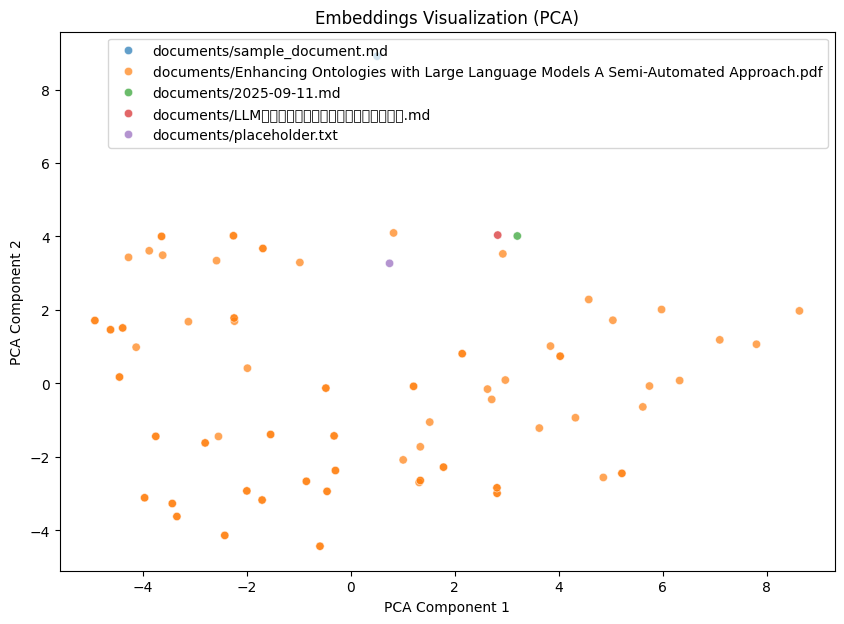

Applying t-SNE for dimensionality reduction (this may take a moment)...


/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12434 (\N{HIRAGANA LETTER WO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikmx/source/personal/test-smith/.venv/lib/pyt

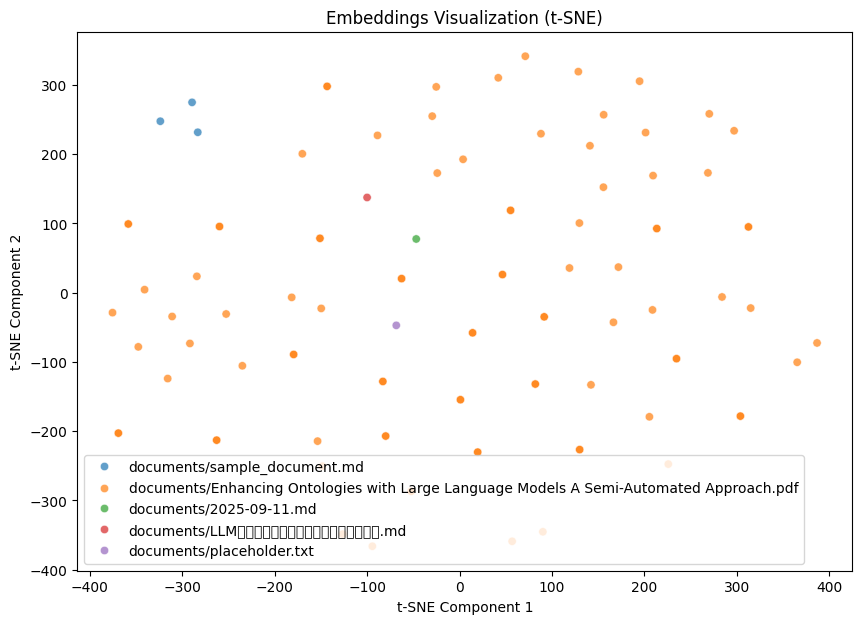

In [11]:
if 'embeddings' in locals() and embeddings is not None and len(embeddings) > 1: 
    print(f"Found {len(embeddings)} embeddings with dimension {len(embeddings[0])}.")
    embeddings_array = np.array(embeddings)

    # Reduce dimensionality for visualization
    if embeddings_array.shape[1] > 2:
        print("Applying PCA for dimensionality reduction...")
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(embeddings_array)
        
        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x=pca_result[:,0], y=pca_result[:,1],
            hue=[m.get('source', 'unknown') if m else 'unknown' for m in metadatas], # Color by 'source' if available
            legend='full',
            alpha=0.7
        )
        plt.title('Embeddings Visualization (PCA)')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

        # t-SNE for potentially better clustering visualization (can be slow for many points)
        if len(embeddings) < 1000: # Limit t-SNE for performance
            print("Applying t-SNE for dimensionality reduction (this may take a moment)...")
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
            tsne_result = tsne.fit_transform(embeddings_array)

            plt.figure(figsize=(10, 7))
            sns.scatterplot(
                x=tsne_result[:,0], y=tsne_result[:,1],
                hue=[m.get('source', 'unknown') if m else 'unknown' for m in metadatas], # Color by 'source' if available
                legend='full',
                alpha=0.7
            )
            plt.title('Embeddings Visualization (t-SNE)')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            plt.show()
        else:
            print("Skipping t-SNE for performance reasons (too many embeddings).")
    else:
        print("Embeddings dimension is 2 or less, no reduction needed for visualization.")
        plt.figure(figsize=(10, 7))
        sns.scatterplot(
            x=embeddings_array[:,0], y=embeddings_array[:,1],
            hue=[m.get('source', 'unknown') if m else 'unknown' for m in metadatas], # Color by 'source' if available
            legend='full',
            alpha=0.7
        )
        plt.title('Embeddings Visualization (Original 2D)')
        plt.xlabel('Embedding Dimension 1')
        plt.ylabel('Embedding Dimension 2')
        plt.show()
else:
    print("No embeddings available or not enough embeddings to visualize for the selected collection.")


## 3.1 Interactive 2D Visualization with Hover

This section creates an interactive plot where you can hover over points to see the document text and source.

In [ ]:
if 'embeddings' in locals() and embeddings is not None and len(embeddings) > 1:
    print(f"Creating interactive 2D visualization...")
    print(f"Processing {len(embeddings)} document embeddings...")
    
    embeddings_array = np.array(embeddings)
    
    # Reduce to 2D using PCA
    if embeddings_array.shape[1] > 2:
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(embeddings_array)
        print(f"PCA explained variance: PC1={pca.explained_variance_ratio_[0]:.2%}, PC2={pca.explained_variance_ratio_[1]:.2%}")
        print(f"Total variance captured: {sum(pca.explained_variance_ratio_):.2%}")
    else:
        pca_result = embeddings_array
    
    # Prepare data for plotly
    # Truncate document text for hover display
    truncated_docs = [doc[:200] + '...' if len(doc) > 200 else doc for doc in documents]
    sources = [m.get('source', 'unknown') if m else 'unknown' for m in metadatas]
    
    # Count unique sources
    unique_sources = list(set(sources))
    print(f"Visualizing {len(unique_sources)} unique source documents")
    
    # Create DataFrame for plotly
    plot_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'source': sources,
        'document': truncated_docs,
        'id': ids
    })
    
    # Create interactive scatter plot with fixed size and aspect ratio
    fig = px.scatter(
        plot_df,
        x='PC1',
        y='PC2',
        color='source',
        hover_data={
            'PC1': ':.3f',
            'PC2': ':.3f',
            'source': True,
            'document': True,
            'id': True
        },
        title=f'Interactive Embeddings Visualization (PCA - 2D)<br><sub>{len(unique_sources)} sources, {len(embeddings)} chunks</sub>',
        labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
        opacity=0.7
    )
    
    fig.update_traces(marker=dict(size=8))
    
    # Set fixed size and make axes equal (square aspect ratio)
    fig.update_layout(
        width=1000,
        height=800,
        hovermode='closest',
        hoverlabel=dict(
            bgcolor="white",
            font_size=12,
            font_family="monospace"
        ),
        # Make plot square and centered
        xaxis=dict(
            scaleanchor="y",
            scaleratio=1,
            constrain='domain'
        ),
        yaxis=dict(
            constrain='domain'
        ),
        # Better legend positioning
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.01,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    fig.show()
else:
    print("No embeddings available for interactive visualization.")

## 3.2 Interactive 4D Pair Plot Visualization

This section creates a pair plot (scatter plot matrix) showing the first 4 principal components. Each subplot shows the relationship between two components, and you can hover over points to see the document text and source. This helps understand the structure of your embeddings in higher dimensions.

In [ ]:
if 'embeddings' in locals() and embeddings is not None and len(embeddings) > 1:
    print(f"Creating interactive 4D pair plot visualization...")
    print(f"Processing {len(embeddings)} document embeddings...")
    
    embeddings_array = np.array(embeddings)
    
    # Reduce to 4D using PCA
    n_components = min(4, embeddings_array.shape[1], len(embeddings))
    if embeddings_array.shape[1] > n_components:
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(embeddings_array)
        explained_variance = pca.explained_variance_ratio_
        print(f"PCA reduced embeddings to {n_components} components")
        print(f"Explained variance ratio: {explained_variance}")
        print(f"Cumulative variance captured: {sum(explained_variance):.2%}")
    else:
        pca_result = embeddings_array[:, :n_components]
        print(f"Using first {n_components} dimensions (no reduction needed)")
    
    # Prepare data for plotly
    truncated_docs = [doc[:300] + '...' if len(doc) > 300 else doc for doc in documents]
    sources = [m.get('source', 'unknown') if m else 'unknown' for m in metadatas]
    
    # Count unique sources
    unique_sources = list(set(sources))
    print(f"Visualizing {len(unique_sources)} unique source documents")
    
    # Create DataFrame with all components
    plot_df = pd.DataFrame({
        f'PC{i+1}': pca_result[:, i] for i in range(n_components)
    })
    plot_df['source'] = sources
    plot_df['document'] = truncated_docs
    plot_df['id'] = ids
    
    # Create scatter matrix using plotly
    dimensions = [f'PC{i+1}' for i in range(n_components)]
    
    # Create custom hover template
    hover_template = '<b>Source:</b> %{customdata[0]}<br>' + \
                    '<b>Document:</b> %{customdata[1]}<br>' + \
                    '<b>ID:</b> %{customdata[2]}<br>'
    
    # Add dimension values to hover
    for i, dim in enumerate(dimensions):
        hover_template += f'<b>{dim}:</b> ' + '{customdata[' + str(i+3) + ']:.3f}<br>'
    
    # Create the scatter matrix with larger fixed size
    fig = px.scatter_matrix(
        plot_df,
        dimensions=dimensions,
        color='source',
        hover_data=['source', 'document', 'id'],
        title=f'Interactive Pair Plot - First {n_components} Principal Components<br><sub>{len(unique_sources)} sources, {len(embeddings)} chunks</sub>',
        opacity=0.7,
        height=1100,
        width=1100
    )
    
    # Update hover template for better formatting
    fig.update_traces(
        marker=dict(size=6),
        diagonal_visible=False,  # Hide diagonal histograms
        showupperhalf=False  # Only show lower triangle
    )
    
    # Update layout with better spacing and legend
    fig.update_layout(
        hovermode='closest',
        hoverlabel=dict(
            bgcolor="white",
            font_size=11,
            font_family="monospace"
        ),
        dragmode='pan',
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.01,
            bgcolor="rgba(255, 255, 255, 0.8)",
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    # Customize axes labels
    for i in range(1, n_components + 1):
        for j in range(1, n_components + 1):
            if i != j:
                fig.update_xaxes(title_text=f'PC{j}', row=i, col=j)
                fig.update_yaxes(title_text=f'PC{i}', row=i, col=j)
    
    fig.show()
    
    # Also create an alternative interactive visualization using subplots for more control
    print("\nCreating alternative detailed pair plot...")
    
    # Calculate number of subplot pairs (lower triangle only)
    subplot_pairs = [(i, j) for i in range(n_components) for j in range(i)]
    n_pairs = len(subplot_pairs)
    
    if n_pairs > 0:
        # Determine grid layout
        n_cols = min(3, n_pairs)
        n_rows = (n_pairs + n_cols - 1) // n_cols
        
        fig2 = make_subplots(
            rows=n_rows, 
            cols=n_cols,
            subplot_titles=[f'PC{j+1} vs PC{i+1}' for i, j in subplot_pairs],
            horizontal_spacing=0.08,
            vertical_spacing=0.10
        )
        
        # Get unique sources for consistent coloring
        unique_sources_list = plot_df['source'].unique()
        colors = px.colors.qualitative.Plotly
        # Extend color palette if we have more sources than colors
        if len(unique_sources_list) > len(colors):
            colors = colors * ((len(unique_sources_list) // len(colors)) + 1)
        source_color_map = {source: colors[i % len(colors)] for i, source in enumerate(unique_sources_list)}
        
        for idx, (i, j) in enumerate(subplot_pairs):
            row = idx // n_cols + 1
            col = idx % n_cols + 1
            
            for source in unique_sources_list:
                source_data = plot_df[plot_df['source'] == source]
                
                fig2.add_trace(
                    go.Scatter(
                        x=source_data[f'PC{j+1}'],
                        y=source_data[f'PC{i+1}'],
                        mode='markers',
                        name=source,
                        marker=dict(
                            size=7,
                            color=source_color_map[source],
                            opacity=0.7,
                            line=dict(width=0.5, color='white')
                        ),
                        customdata=np.column_stack((
                            source_data['source'],
                            source_data['document'],
                            source_data['id']
                        )),
                        hovertemplate=(
                            '<b>Source:</b> %{customdata[0]}<br>' +
                            f'<b>PC{j+1}:</b> %{{x:.3f}}<br>' +
                            f'<b>PC{i+1}:</b> %{{y:.3f}}<br>' +
                            '<b>Document:</b><br>%{customdata[1]}<br>' +
                            '<b>ID:</b> %{customdata[2]}<br>' +
                            '<extra></extra>'
                        ),
                        showlegend=(idx == 0),  # Only show legend for first subplot
                        legendgroup=source
                    ),
                    row=row,
                    col=col
                )
            
            # Update axes for each subplot with better formatting
            fig2.update_xaxes(
                title_text=f'PC{j+1}', 
                row=row, 
                col=col,
                showgrid=True,
                gridwidth=1,
                gridcolor='LightGray'
            )
            fig2.update_yaxes(
                title_text=f'PC{i+1}', 
                row=row, 
                col=col,
                showgrid=True,
                gridwidth=1,
                gridcolor='LightGray'
            )
        
        # Calculate height based on number of rows
        subplot_height = max(400 * n_rows, 800)
        
        fig2.update_layout(
            height=subplot_height,
            width=1400,
            title_text=f'Detailed Pair Plot - First {n_components} Principal Components<br><sub>{len(unique_sources)} sources, {len(embeddings)} chunks</sub>',
            title_font_size=16,
            hovermode='closest',
            hoverlabel=dict(
                bgcolor="white",
                font_size=11,
                font_family="monospace"
            ),
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
                x=0.99,
                bgcolor="rgba(255, 255, 255, 0.9)",
                bordercolor="Black",
                borderwidth=1
            ),
            showlegend=True
        )
        
        fig2.show()
    
else:
    print("No embeddings available for 4D pair plot visualization.")


## 4. Search within a Collection (Optional)

You can perform a similarity search within the selected collection. Enter a query text and specify how many results you want.


In [8]:

if 'selected_collection' in locals() and selected_collection:
    query_text = input("Enter a query to search within the collection (or leave blank to skip): ").strip()
    if query_text:
        try:
            n_results_str = input("How many results to retrieve? (default: 5): ").strip()
            n_results = int(n_results_str) if n_results_str.isdigit() else 5

            search_results = selected_collection.query(
                query_texts=[query_text],
                n_results=n_results,
                include=['documents', 'metadatas', 'distances']
            )

            print(f"Search Results for '{query_text}':")
            if search_results['documents'] and search_results['documents'][0]:
                search_df = pd.DataFrame({
                    'document': search_results['documents'][0],
                    'metadata': search_results['metadatas'][0],
                    'distance': search_results['distances'][0]
                })
                display(search_df)
            else:
                print("No results found for your query.")
        except Exception as e:
            print(f"Error during search: {e}")
    else:
        print("Query text was empty, skipping search.")
else:
    print("Cannot perform search without a selected collection.")


Query text was empty, skipping search.
